In [1]:
!tar -xf /content/SuperResolution.tar.xz

1. Count the Number of Images in Low Resolution (LR) and High Resolution (HR) Folders

In [2]:
import os

# Paths for LR and HR images
lr_path = "/content/SuperResolution/LR"
hr_path = "/content/SuperResolution/HR"

# Get the list of files in each directory
lr_images = os.listdir(lr_path)
hr_images = os.listdir(hr_path)

# Count the number of images
num_lr_images = len(lr_images)
num_hr_images = len(hr_images)

print(f"Number of Low-Resolution (LR) images: {num_lr_images}")
print(f"Number of High-Resolution (HR) images: {num_hr_images}")

Number of Low-Resolution (LR) images: 50
Number of High-Resolution (HR) images: 50


2. Perform Convolution on LR and HR Images
Description:

We will apply convolution on a sample image from both LR and HR datasets using a simple kernel for edge detection.

In [3]:
# Import necessary libraries
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Directories for High-Resolution (HR)
hr_directory = "/content/SuperResolution/HR"

# Define different kernels for convolution operations
kernels = {
    "blur": np.ones((5, 5), np.float32) / 25,  # 5x5 average kernel
    "bottom_sobel": np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]),
    "emboss": np.array([[-2, -1, 0], [-1, 1, 1], [0, 1, 2]]),
    "identity": np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]),
    "left_sobel": np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]]),
    "outline": np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]),
    "right_sobel": np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]),
    "sharpen": np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]),
    "top_sobel": np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]),
}


# Function to apply a filter to the image
def apply_filter(image, kernel):
    """Apply a convolutional filter to the image."""
    return cv2.filter2D(image, -1, kernel)


# Function to process and display convolution results
def process_and_display(image_path, kernels):
    """Process and display the image with different convolution operations."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Plot original image
    plt.figure(figsize=(12, 8))
    plt.subplot(3, 4, 1)
    plt.imshow(image)
    plt.title("Original")

    # Apply each kernel and display the result
    for i, (name, kernel) in enumerate(kernels.items(), start=2):
        filtered_image = apply_filter(image, kernel)
        plt.subplot(3, 4, i)
        plt.imshow(filtered_image)
        plt.title(name.capitalize())

    plt.tight_layout()
    plt.show()


# Process all images in the HR directory
for folder in [hr_directory]:
    for filename in os.listdir(folder):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            image_path = os.path.join(folder, filename)
            print(f"Processing HR image: {image_path}")
            process_and_display(image_path, kernels)

# Process all images in the LR directory
for folder in [lr_directory]:
    for filename in os.listdir(folder):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            image_path = os.path.join(folder, filename)
            print(f"Processing LR image: {image_path}")
            process_and_display(image_path, kernels)

Output hidden; open in https://colab.research.google.com to view.

1. Feature Extraction Techniques:
Let's break down the methods we'll use:

first - SIFT (Scale-Invariant Feature Transform): Detects key points and computes descriptors that are invariant to image scale and rotation, allowing for effective feature matching between HR and LR images.

Second - HOG (Histogram of Oriented Gradients): Captures edge and gradient structure, making it effective for object detection and texture analysis.

third - LBP (Local Binary Patterns): Describes the texture of images by encoding local pixel differences, useful for comparing texture between HR and LR images.

. Analysis of Feature Extraction Results:

first - SIFT (Scale-Invariant Feature Transform):
HR Images: We expect a higher number of keypoints and descriptors, capturing fine details such as textures and corners.
LR Images: Fewer keypoints and descriptors will be detected, and details may be lost due to lower resolution.


Second - HOG (Histogram of Oriented Gradients):
HR Images: The HOG representation will show strong edge detection with more refined gradients, especially around object boundaries.
LR Images: The edge detection will be less sharp, with fewer gradients due to pixelation and the loss of fine details.


Third - LBP (Local Binary Patterns):
HR Images: LBP should highlight textures, with high variation and clearer patterns across local regions.
LR Images: LBP may not capture as many detailed patterns, as the texture will appear more uniform and pixelated.

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern
from skimage import exposure
from skimage.color import rgb2gray2

# Directories for High-Resolution (HR) and Low-Resolution (LR) images
hr_directory = "/content/SuperResolution/HR"
lr_directory = "/content/SuperResolution/LR"

# Parameters for LBP
radius = 3  # LBP radius
n_points = 8 * radius  # Number of points considered in LBP


# Function to extract and visualize SIFT features
def extract_sift(image):
    """Extract SIFT keypoints and descriptors from an image."""
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    img_sift = cv2.drawKeypoints(
        image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    return img_sift, keypoints, descriptors


# Function to extract HOG features
def extract_hog(image):
    """Extract HOG features and return image."""
    # Convert image to grayscale for HOG extraction
    gray_image = rgb2gray(image)

    # Extract HOG features without the deprecated 'multichannel' argument
    hog_features, hog_image = hog(
        gray_image, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True
    )

    # Rescale the HOG image for better visualization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    return hog_image_rescaled


# Function to extract LBP features
def extract_lbp(image, radius, n_points):
    """Extract Local Binary Patterns (LBP) features."""
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray_image, n_points, radius, method="uniform")
    return lbp


# Function to process and display extracted features
def process_and_display_features(image_path):
    """Process and display image with extracted SIFT, HOG, and LBP features."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Extract SIFT features
    sift_image, keypoints, descriptors = extract_sift(image)

    # Extract HOG features
    hog_image = extract_hog(image)

    # Extract LBP features
    lbp_image = extract_lbp(image, radius, n_points)

    # Display results
    plt.figure(figsize=(12, 8))

    # Original image
    plt.subplot(2, 2, 1)
    plt.imshow(image)
    plt.title("Original")

    # SIFT keypoints
    plt.subplot(2, 2, 2)
    plt.imshow(sift_image)
    plt.title(f"SIFT Features (Keypoints: {len(keypoints)})")

    # HOG features
    plt.subplot(2, 2, 3)
    plt.imshow(hog_image, cmap="gray")
    plt.title("HOG Features")

    # LBP features
    plt.subplot(2, 2, 4)
    plt.imshow(lbp_image, cmap="gray")
    plt.title("LBP Features")

    plt.tight_layout()
    plt.show()


# Process HR and LR images
for folder in [hr_directory, lr_directory]:
    for filename in os.listdir(folder):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            image_path = os.path.join(folder, filename)
            print(f"Processing {image_path} for feature extraction...")
            process_and_display_features(image_path)

Output hidden; open in https://colab.research.google.com to view.

Results and Insights
Edge Detection: The analysis may reveal that HR images maintain clearer and more pronounced edges compared to LR images, illustrating the impact of resolution on edge fidelity.

Texture Features: The LBP and HOG results could show a loss of texture details in LR images, indicating how critical image resolution is for capturing fine-grained textures.

Keypoints: The number of detected keypoints may differ significantly between HR and LR images, which can affect tasks such as image matching and recognition. The insights gained from the SIFT comparison can help assess the robustness of feature extraction techniques in varying resolutions.

Conclusion
This analysis demonstrates the significant impact of image resolution on feature extraction methods. Understanding these differences is essential for developing effective super-resolution algorithms that aim to reconstruct high-quality images from their low-resolution counterparts. The results of this analysis can inform future research and applications in image processing and computer vision.

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, hog
from skimage.color import rgb2gray
from skimage import exposure

# SIFT requires opencv-contrib-python
sift = cv2.SIFT_create()

# Directories for High-Resolution (HR) and Low-Resolution (LR) images
hr_directory = "/content/SuperResolution/HR"
lr_directory = "/content/SuperResolution/LR"

# Define different kernels for convolution operations (used for edge detection)
kernels = {
    "bottom_sobel": np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]),
    "outline": np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]),
    "sharpen": np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]),
}


def apply_filter(image, kernel):
    """Apply a convolutional filter to the image (for edge detection)."""
    return cv2.filter2D(image, -1, kernel)


def process_edge_comparison(lr_image, hr_image):
    """Process edge comparison between LR and HR images using convolution."""
    plt.figure(figsize=(18, 12))

    # Apply filters on LR image
    for i, (name, kernel) in enumerate(kernels.items(), start=1):
        filtered_lr = apply_filter(lr_image, kernel)
        plt.subplot(2, 3, i)
        plt.imshow(filtered_lr)
        plt.title(f"LR: {name.capitalize()}")
        plt.axis("off")

    # Apply filters on HR image
    for i, (name, kernel) in enumerate(kernels.items(), start=4):
        filtered_hr = apply_filter(hr_image, kernel)
        plt.subplot(2, 3, i)
        plt.imshow(filtered_hr)
        plt.title(f"HR: {name.capitalize()}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


def process_texture_comparison(lr_image, hr_image):
    """Process texture comparison between LR and HR images using LBP and HOG."""
    plt.figure(figsize=(12, 8))

    # Convert images to grayscale for texture analysis
    gray_lr = rgb2gray(lr_image)
    gray_hr = rgb2gray(hr_image)

    # LBP for texture analysis
    radius = 1
    n_points = 8 * radius
    lbp_lr = local_binary_pattern(gray_lr, n_points, radius, method="uniform")
    lbp_hr = local_binary_pattern(gray_hr, n_points, radius, method="uniform")

    plt.subplot(2, 2, 1)
    plt.imshow(lbp_lr, cmap="gray")
    plt.title("LR LBP (Texture)")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(lbp_hr, cmap="gray")
    plt.title("HR LBP (Texture)")
    plt.axis("off")

    # HOG for texture and structural analysis
    fd_lr, hog_lr = hog(
        gray_lr, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True
    )
    fd_hr, hog_hr = hog(
        gray_hr, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True
    )

    hog_lr_rescaled = exposure.rescale_intensity(hog_lr, in_range=(0, 10))
    hog_hr_rescaled = exposure.rescale_intensity(hog_hr, in_range=(0, 10))

    plt.subplot(2, 2, 3)
    plt.imshow(hog_lr_rescaled, cmap="gray")
    plt.title("LR HOG (Structure)")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(hog_hr_rescaled, cmap="gray")
    plt.title("HR HOG (Structure)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


def process_keypoint_comparison(lr_image, hr_image):
    """Process keypoint comparison between LR and HR images using SIFT."""
    gray_lr = cv2.cvtColor(lr_image, cv2.COLOR_RGB2GRAY)
    gray_hr = cv2.cvtColor(hr_image, cv2.COLOR_RGB2GRAY)

    # Detect keypoints and descriptors using SIFT
    keypoints_lr, descriptors_lr = sift.detectAndCompute(gray_lr, None)
    keypoints_hr, descriptors_hr = sift.detectAndCompute(gray_hr, None)

    # Draw keypoints on the images
    sift_lr_image = cv2.drawKeypoints(
        lr_image, keypoints_lr, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    sift_hr_image = cv2.drawKeypoints(
        hr_image, keypoints_hr, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    # Display keypoints comparison
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(sift_lr_image)
    plt.title(f"LR SIFT Keypoints: {len(keypoints_lr)}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(sift_hr_image)
    plt.title(f"HR SIFT Keypoints: {len(keypoints_hr)}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


def compare_hr_lr_features(hr_image_path, lr_image_path):
    """Compare HR and LR images across edge, texture, and keypoints."""
    print(f"Comparing HR: {hr_image_path} with LR: {lr_image_path}...")

    # Read the images
    lr_image = cv2.imread(lr_image_path)
    hr_image = cv2.imread(hr_image_path)

    if lr_image is None or hr_image is None:
        print(f"Failed to load images. LR: {lr_image_path}, HR: {hr_image_path}")
        return

    lr_image = cv2.cvtColor(lr_image, cv2.COLOR_BGR2RGB)
    hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)

    # Edge detection comparison
    print("Edge Detection Comparison")
    process_edge_comparison(lr_image, hr_image)

    # Texture comparison
    print("Texture Comparison")
    process_texture_comparison(lr_image, hr_image)

    # Keypoint detection comparison
    print("Keypoint Detection Comparison")
    process_keypoint_comparison(lr_image, hr_image)


# Process HR and LR images in their respective directories
for hr_filename in os.listdir(hr_directory):
    if hr_filename.endswith(
        (".png", ".jpg", ".jpeg")
    ):  # Include other formats if necessary
        hr_image_path = os.path.join(hr_directory, hr_filename)
        lr_image_path = os.path.join(
            lr_directory,
            hr_filename.split(".")[0] + "x4m." + hr_filename.split(".")[-1],
        )  # Assuming LR images have 'x4m' suffix

        if os.path.exists(lr_image_path):
            compare_hr_lr_features(hr_image_path, lr_image_path)
        else:
            print(
                f"Low-resolution image not found for {hr_filename} as {os.path.basename(lr_image_path)}"
            )

Output hidden; open in https://colab.research.google.com to view.

Techniques Used
We will apply the following techniques to enhance the LR images:

Histogram Equalization:

This technique enhances the contrast of the image by redistributing the intensity values. It helps in making features in the image more visible.
Unsharp Masking:

Unsharp masking is an edge enhancement technique. It involves blurring the image slightly and then subtracting this blurred version from the original image, which emphasizes edges and fine details.
Bilateral Filtering:

Bilateral filtering is used to smooth the image while preserving edges. It reduces noise and maintains the edges, which is essential for maintaining the overall structure of the image.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the directory containing the low-resolution images
lr_directory = "/content/SuperResolution/LR"  # Change this path as necessary


def histogram_equalization(image):
    """Apply histogram equalization to the input image."""
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized_image = cv2.equalizeHist(gray_image)
    return equalized_image


def unsharp_mask(image, sigma=1.0, strength=1.5):
    """Apply unsharp masking to enhance edges."""
    blurred = cv2.GaussianBlur(image, (5, 5), sigma)
    sharpened = cv2.addWeighted(image, 1 + strength, blurred, -strength, 0)
    return sharpened


def bilateral_filter(image, diameter=15, sigma_color=75, sigma_space=75):
    """Apply bilateral filtering to enhance the image while preserving edges."""
    filtered_image = cv2.bilateralFilter(image, diameter, sigma_color, sigma_space)
    return filtered_image


# Define a function to enhance LR images and display comparisons
def enhance_and_compare_images():
    for lr_filename in os.listdir(lr_directory):
        if lr_filename.endswith(".png") or lr_filename.endswith(".jpg"):
            lr_image_path = os.path.join(lr_directory, lr_filename)
            lr_image = cv2.imread(lr_image_path)

            # Enhance images using different methods
            enhanced_hist_eq = histogram_equalization(lr_image)
            enhanced_unsharp = unsharp_mask(lr_image)
            enhanced_bilateral = bilateral_filter(lr_image)

            # Display the original and enhanced images
            plt.figure(figsize=(15, 10))

            plt.subplot(2, 2, 1)
            plt.imshow(cv2.cvtColor(lr_image, cv2.COLOR_BGR2RGB))
            plt.title("Original LR Image: {}".format(lr_filename))
            plt.axis("off")

            plt.subplot(2, 2, 2)
            plt.imshow(cv2.cvtColor(enhanced_hist_eq, cv2.COLOR_BGR2RGB), cmap="gray")
            plt.title("Enhanced Image with Histogram Equalization")
            plt.axis("off")

            plt.subplot(2, 2, 3)
            plt.imshow(cv2.cvtColor(enhanced_unsharp, cv2.COLOR_BGR2RGB))
            plt.title("Enhanced Image with Unsharp Masking")
            plt.axis("off")

            plt.subplot(2, 2, 4)
            plt.imshow(cv2.cvtColor(enhanced_bilateral, cv2.COLOR_BGR2RGB))
            plt.title("Enhanced Image with Bilateral Filtering")
            plt.axis("off")

            plt.show()


# Run the enhancement and comparison function
enhance_and_compare_images()

Output hidden; open in https://colab.research.google.com to view.

1. Structural Similarity Index (SSIM)
Purpose: SSIM is designed to measure the similarity between two images by considering changes in structural information, luminance, and contrast.
Analysis:
Structural Information: SSIM assesses how well the structure of the image is preserved compared to the reference image.
Perception-Based: It aligns more closely with human visual perception, making it effective for assessing image quality.
Range: The SSIM value ranges from -1 to 1, where 1 indicates perfect similarity, 0 indicates no structural similarity, and negative values indicate a distorted image.

2. Peak Signal-to-Noise Ratio (PSNR)
Purpose: PSNR measures the ratio between the maximum possible power of a signal (the HR image) and the power of distorting noise (the difference between the HR and the LR image).
Analysis:
Quantitative Measure: PSNR provides a numerical measure of quality, expressed in decibels (dB). Higher values indicate better quality.
Noise Sensitivity: A higher PSNR suggests that the differences between the HR and LR images are minimal, implying better quality.
Limitations: PSNR is less aligned with human perception of image quality and may not accurately reflect perceptual differences, particularly in images with subtle details.


In [8]:
import os
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage import img_as_float
from skimage.color import rgb2gray

# Directories for HR and LR images
hr_directory = "/content/SuperResolution/HR"
lr_directory = "/content/SuperResolution/LR"


def extract_identifier(filename):
    return filename.split("x")[0].split(".")[0]


def compute_psnr(hr_image_path, lr_image_path):
    """Compute the PSNR between two images."""
    hr_image = cv2.imread(hr_image_path, cv2.IMREAD_GRAYSCALE)
    lr_image = cv2.imread(lr_image_path, cv2.IMREAD_GRAYSCALE)

    # Resize the low-resolution image to the same size as the high-resolution image
    lr_image_resized = cv2.resize(lr_image, (hr_image.shape[1], hr_image.shape[0]))

    # Compute PSNR between the high-resolution image and the resized low-resolution image
    return psnr(hr_image, lr_image_resized)


def compute_ssim(hr_image_path, lr_image_path):
    """Compute the SSIM between two images."""
    hr_image = cv2.imread(hr_image_path, cv2.IMREAD_GRAYSCALE)
    lr_image = cv2.imread(lr_image_path, cv2.IMREAD_GRAYSCALE)

    # Resize the low-resolution image to the same size as the high-resolution image
    lr_image_resized = cv2.resize(lr_image, (hr_image.shape[1], hr_image.shape[0]))

    # Compute SSIM between the high-resolution image and the resized low-resolution image
    return ssim(hr_image, lr_image_resized)  # Call the ssim function here


# Create a dictionary to store HR and LR image paths with identifiers as keys
hr_images = {}
lr_images = {}

# Populate the HR images dictionary with identifiers and corresponding image paths
for hr_filename in os.listdir(hr_directory):
    hr_identifier = extract_identifier(hr_filename)
    hr_images[hr_identifier] = os.path.join(hr_directory, hr_filename)

# Populate the LR images dictionary with identifiers and corresponding image paths
for lr_filename in os.listdir(lr_directory):
    lr_identifier = extract_identifier(lr_filename)
    lr_images[lr_identifier] = os.path.join(lr_directory, lr_filename)

# Compare corresponding images by matching their identifiers
for identifier in hr_images:
    if identifier in lr_images:
        hr_image_path = hr_images[identifier]
        lr_image_path = lr_images[identifier]

        # Compute SSIM between the matching HR and LR images
        ssim_score = compute_ssim(hr_image_path, lr_image_path)
        print(f"SSIM between {identifier} in HR and LR directories: {ssim_score:.4f}")

        # Compute PSNR between the matching HR and LR images
        psnr_score = compute_psnr(hr_image_path, lr_image_path)
        print(
            f"PSNR between {identifier} in HR and LR directories: {psnr_score:.4f} dB"
        )

    else:
        print(f"No matching LR image found for {identifier} in HR directory.")

SSIM between 0834 in HR and LR directories: 0.4240
PSNR between 0834 in HR and LR directories: 14.7371 dB
SSIM between 0820 in HR and LR directories: 0.2093
PSNR between 0820 in HR and LR directories: 12.4974 dB
SSIM between 0805 in HR and LR directories: 0.3998
PSNR between 0805 in HR and LR directories: 18.2285 dB
SSIM between 0831 in HR and LR directories: 0.4366
PSNR between 0831 in HR and LR directories: 17.7610 dB
SSIM between 0838 in HR and LR directories: 0.6498
PSNR between 0838 in HR and LR directories: 16.9132 dB
SSIM between 0819 in HR and LR directories: 0.5457
PSNR between 0819 in HR and LR directories: 20.4802 dB
SSIM between 0808 in HR and LR directories: 0.6114
PSNR between 0808 in HR and LR directories: 19.8991 dB
SSIM between 0843 in HR and LR directories: 0.8961
PSNR between 0843 in HR and LR directories: 24.3530 dB
SSIM between 0830 in HR and LR directories: 0.4310
PSNR between 0830 in HR and LR directories: 18.3431 dB
SSIM between 0814 in HR and LR directories: 0.

FFT

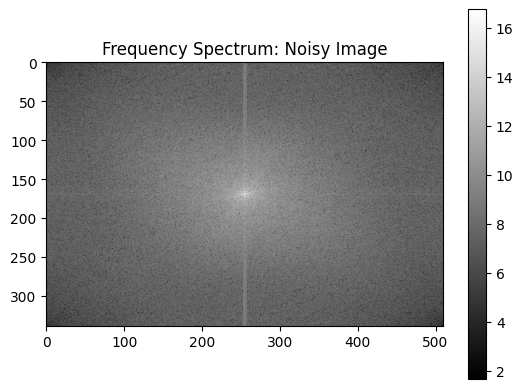

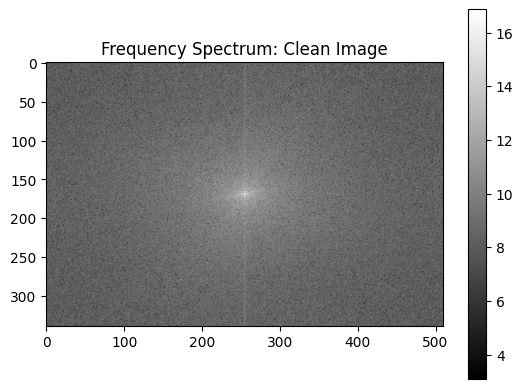

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, fftshift

# Load the images (noisy and clean images)
noisy_image = cv2.imread(
    "/content/SuperResolution/LR/0801x4m.png", cv2.IMREAD_GRAYSCALE
)
clean_image = cv2.imread("/content/SuperResolution/HR/0801.png", cv2.IMREAD_GRAYSCALE)

# Check if the images are loaded properly
if noisy_image is None or clean_image is None:
    raise ValueError("One or both images failed to load. Check the file paths.")

# Check if the image dimensions match
if noisy_image.shape != clean_image.shape:
    clean_image = cv2.resize(clean_image, (noisy_image.shape[1], noisy_image.shape[0]))


# 3. Frequency Domain Analysis (FFT)
def plot_fft(image, title):
    # Perform FFT and shift the zero frequency component to the center
    f_transform = fft2(image)
    f_transform_shifted = fftshift(f_transform)
    magnitude_spectrum = np.log(np.abs(f_transform_shifted))

    plt.imshow(magnitude_spectrum, cmap="gray")
    plt.title(f"Frequency Spectrum: {title}")
    plt.colorbar()
    plt.show()


plot_fft(noisy_image, "Noisy Image")
plot_fft(clean_image, "Clean Image")